In [1]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.4 MB/s eta 0:00:00


In [2]:
DATA_PATH = '/kaggle/input/dfdc20frames/'

In [3]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter, defaultdict
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
df = pd.read_csv(DATA_PATH + 'faces_metadata.csv')
df

,file_path,label
0,deepfake-detection/FAKE/FAKE/dfdc_train_part_9...,FAKE
1,deepfake-detection/FAKE/FAKE/dfdc_train_part_1...,FAKE
2,deepfake-detection/FAKE/FAKE/dfdc_train_part_8...,FAKE
3,deepfake-detection/FAKE/FAKE/dfdc_train_part_7...,FAKE
4,deepfake-detection/FAKE/FAKE/dfdc_train_part_4...,FAKE
...,...,...
5014,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5015,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5016,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5017,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL


In [7]:
!ls /kaggle/input/

dfdc20frames  stepdata20


In [8]:
def convert_path(path: str) -> str:
    for i in range(10):
        path = path.replace(f'{i:02}', str(i))
    return path


def process_file_paths(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((DATA_PATH + file_path, row['label']))

    return result


def get_video_info(video_path: str) -> Union[Tuple[int, float], Tuple[None, None]]:
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Не вдалося відкрити файл: {video_path}")
        return None, None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)  
    cap.release()
    
    return frame_count, fps

In [9]:
video_stats = []
result = process_file_paths(df)

for video_path, label in result:
    frame_count, fps = get_video_info(video_path)
    if frame_count is not None and fps is not None:
        video_stats.append({
            'file_path': video_path,
            'label': label,
            'frames': frame_count,
            'fps': fps
        })

df = pd.DataFrame(video_stats)

stats_fps = df['fps'].describe()
stats_frames = df['frames'].describe()

print("FPS статистика:")
print(stats_fps)

print("\nКількість кадрів статистика:")
print(stats_frames)
#df = df[df['fps'] >= 28]

FPS статистика:
count    5019.000000
mean       29.478521
std         1.792622
min        12.474000
25%        29.969000
50%        29.970000
75%        29.970000
max        30.080000
Name: fps, dtype: float64

Кількість кадрів статистика:
count    5019.0
mean       20.0
std         0.0
min        20.0
25%        20.0
50%        20.0
75%        20.0
max        20.0
Name: frames, dtype: float64


In [10]:
files_to_remove_unique = set(['avjwhrqbwl_0', 'bpqrwvichd_0', 'cctrhqvein_0', 'eupisnxhsb_0', 'gerhijzwvq_0', 'katmliewya_0', 'onoowfeded_0',
                  'pydbvfkslp_0', 'qqisdvvgfi_0', 'sclvdumbkh_0', 'snphlfsrmr_0', 'spxqkpmopb_0', 'vugbaeziku_0', 'vvtcvjvkqx_0',
                   'xuoqfchsfj_0', 'zdkyyawcwe_0', 'mshechsves_0', 'ejwvqbeyef_0', 'pqbyjmgmrk_0', 'drmtykanjz_0', 'fktxniwzxe_0',
                   'iynuflmhau_0', 'kligyzlcuk_0', 'kifzxbsnku_0', 'kifzxbsnku_0', 'euarbrmuzs_0', 'fodhjwybqm_0', 'pbpgyiimwt_0',
                   'qmqfqyqmfx_0', 'thmwcolqan_0', 'xhwacojjdg_0', 'xkwjjjkcam_0', 'zktuaqrqqv_0', 'cioizeilvz_0', 'cotvlcroov_0',
                   'tuxbzsrszr_0', 'ynpqkrmuap_0', 'gomxkjifiu_0', 'ukrckkvaqi_0', 'vlcbaytswm_0', 'wmobvmntzu_0', 'ydqeopjemz_0',
                   'cxfbhgmuyu_0', 'hqqmtxvbjj_0', 'jaetnqgktl_0', 'yurtzoovou_0', 'hlcqjuwpsd_0', 'iarobzzslu_0', 'ailmasxkxb_0',
                   'bbwrqfawrj_0', 'cefzoeryat_0', 'egcuyhyvsm_0', 'eqgipviesf_0', 'fwekcrqdak_0', 'giqncczwue_0', 'hslupphtel_0',
                   'jmqmljznhv_0', 'lkbpavasad_0', 'osqruujwxd_0', 'pjibpowymk_0', 'ptchnzeeqc_0', 'sppyyoqaey_0', 'tohrqjyter_0',
                   'xzcexrifxq_0', 'aahncigwte_0', 'fszexmwczt_0', 'fszexmwczt_0', 'lkgrqfcrps_0', 'cdgrttukjn_0', 'eclxonfxph_0',
                   'eclxonfxph_0', 'gzbagbdubm_0', 'hhhvnhhqsc_0', 'junllgghcq_0', 'qyefejorlb_0'
                  ])
files_to_remove = list(files_to_remove_unique)
#df = df[~df['file_path'].apply(lambda x: any(file in x for file in files_to_remove))]
#df

In [11]:
def df_to_list(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((file_path, row['label']))

    return result


result = df_to_list(df)
#result

In [12]:
groups = defaultdict(list)
for file_path, label in result:
    base_name = os.path.basename(file_path).split('_')[0]
    groups[base_name].append((file_path, label))

single_element_groups = [group for group in groups.values() if len(group) == 1]

#single_element_groups


In [13]:
train_files = [item for group in single_element_groups for item in group]

In [14]:
#train_files

In [15]:
df = pd.DataFrame(train_files, columns=['video_path', 'label'])
#real_videos = df[df['label'] == 'REAL']
#fake_videos = df[df['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#df = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)

train_data = df[~df['video_path'].str.contains('dfdc_train_part_8|dfdc_train_part_7')]
val_data = df[df['video_path'].str.contains('dfdc_train_part_8')]
test_data = df[df['video_path'].str.contains('dfdc_train_part_7')]

In [16]:
for i in range(11):
    subset_df = df[df['video_path'].str.contains(f'dfdc_train_part_{i}')]
    label_distribution = subset_df['label'].value_counts()
    print(i)
    print(label_distribution)

0
label
FAKE    143
REAL     68
Name: count, dtype: int64
1
label
FAKE    628
REAL    371
Name: count, dtype: int64
2
label
REAL    203
FAKE    157
Name: count, dtype: int64
3
label
REAL    199
FAKE    165
Name: count, dtype: int64
4
label
FAKE    158
REAL    154
Name: count, dtype: int64
5
label
REAL    310
FAKE    240
Name: count, dtype: int64
6
label
REAL    390
FAKE    380
Name: count, dtype: int64
7
label
REAL    306
FAKE    267
Name: count, dtype: int64
8
label
REAL    254
FAKE    214
Name: count, dtype: int64
9
label
REAL    258
FAKE    154
Name: count, dtype: int64
10
label
FAKE    429
REAL    278
Name: count, dtype: int64


In [17]:
#train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=17)

print("Train set size:", len(train_data))
print("Val set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 3978
Val set size: 468
Test set size: 573


In [18]:
test_data

,video_path,label
3,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
8,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
12,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
20,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
21,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
...,...,...
3795,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL
3796,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL
3797,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL
3798,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL


In [19]:
#real_videos = train_data[train_data['label'] == 'REAL']
#fake_videos = train_data[train_data['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#train_data = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)
#train_data

<Axes: >

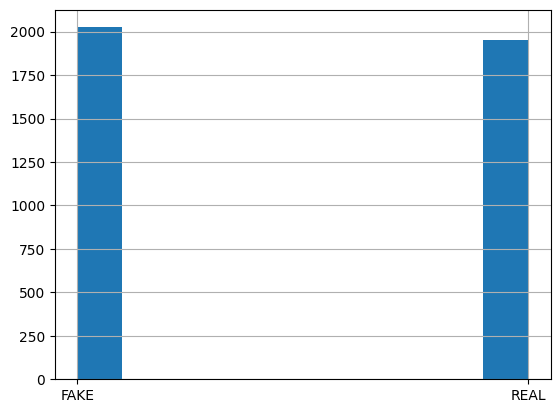

In [20]:
train_data['label'].hist()

<Axes: >

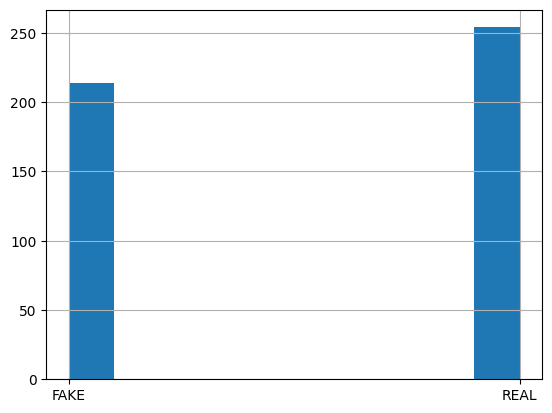

In [21]:
val_data['label'].hist()

<Axes: >

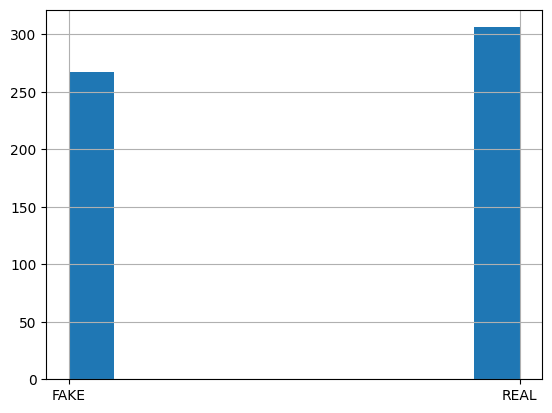

In [22]:
test_data['label'].hist()

In [23]:
print("Train set size:", len(train_data))
print("Val set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 3978
Val set size: 468
Test set size: 573


In [24]:
train_data.to_csv("train_dataset.csv", index=False)
val_data.to_csv("val_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

In [25]:
def create_json_from_csv(input_csv: str, output_json: str) -> None:
    df = pd.read_csv(input_csv)
    result: Dict[str, str] = {}

    for _, row in df.iterrows():
        file_path = row['video_path']
        label = row['label']

        result[file_path] = {'label': label}

    with open(output_json, 'w') as json_file:
        json.dump(result, json_file, indent=4)


create_json_from_csv('train_dataset.csv', 'output_balenced_train.json')
create_json_from_csv('val_dataset.csv', 'output_balenced_val.json')
create_json_from_csv('test_dataset.csv', 'output_balenced_test.json')

In [26]:
with open('output_balenced_train.json', 'r') as json_file:
    data = json.load(json_file)

label_counts = Counter()

for item in data.values():
    label_counts[item['label']] += 1

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: FAKE, Count: 2025
Label: REAL, Count: 1953


In [27]:
from torchvision import transforms


class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, n_frames: int, df_path: str, device, cache_folder: str, image_size=(224, 224), transform=None):

        self.n_frames = n_frames
        self.videos = []
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.image_size = image_size
        
        self.transform = transform
        
        self.detector = MTCNN(device=device, post_process=False)

        with open(df_path) as f:
            videos = json.load(f)
            videos = [(video, metadata) for (video, metadata) in videos.items()]
            self.videos += videos

    def __getitem__(self, n):
        video, metadata = self.videos[n]
        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Загальна кількість кадрів у відео
        start_frame = random.randint(0, max(0, total_frames - self.n_frames))  # Випадковий стартовий кадр

        # Перемотка до стартового кадру
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        frames = []

        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resize = (self.image_size[0], self.image_size[1])
            frame = cv2.resize(frame, resize)
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame)

        cap.release()

        frames = torch.stack(frames).to(self.device)
        
        if self.transform:
            frames = self.transform(frames)

        label = 0.0
        if metadata['label'] == 'FAKE':
            label = 1.0

        return frames, torch.FloatTensor([label]).to(self.device)


    def __len__(self):
        return len(self.videos)

    
class SameAugmentation:
    def __init__(self, augmentations):
        """
        Args:
            augmentations (callable): Трансформації, що застосовуються до всіх кадрів.
        """
        self.augmentations = augmentations

    def __call__(self, frames):
        # Ініціалізуємо однакове перетворення
        seed = torch.randint(0, 2**32, (1,)).item()

        # Застосовуємо однакові трансформації до всіх кадрів
        augmented_frames = []
        for frame in frames:
            torch.manual_seed(seed)  # Встановлюємо однаковий seed
            augmented_frames.append(self.augmentations(frame))
        
        return torch.stack(augmented_frames)

Label: tensor([1.], device='cuda:0')


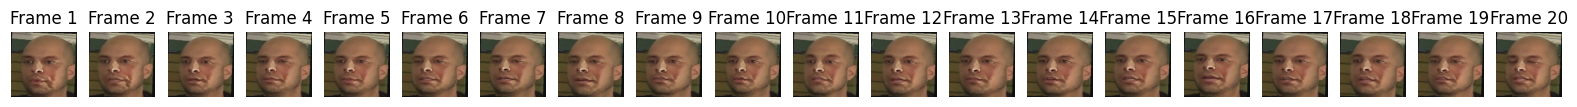

In [28]:
def test_train_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transfor = SameAugmentation(
        transforms.Compose([
            # Горизонтальне відображення
            transforms.RandomHorizontalFlip(p=0.5),
            # Легке афінне перетворення
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            # Легкий поворот
            transforms.RandomRotation(degrees=5, fill=0),
            # Розмиття для імітації відео низької якості
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            # Колірні зміни (яскравість, контраст)
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            # Перетворення в сірий для певного шуму
            transforms.RandomGrayscale(p=0.1),
        ])
    )
    
    dataset = VideoDataset(20, 'output_balenced_train.json', device, 'cache', (224, 224), transfor)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_train_data()

Label: tensor([1.], device='cuda:0')


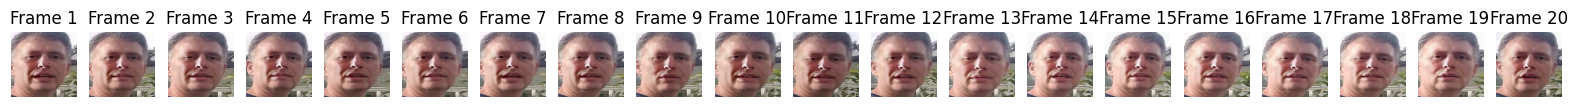

In [29]:
def test_test_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = VideoDataset(20, 'output_balenced_test.json', device, 'cache', (224, 224), None)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_test_data()

In [34]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    minposs = val_losses.index(min(val_losses)) 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [35]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [43]:
def train_model(model, hparms: dict[str, Union[int, float]], path_train: str, path_test: str, size: tuple[int], device, name: str, checkpoint_path: str = None):
    batch_size = hparms['batch_size']
    num_epochs = hparms['num_epochs']
    n_frames = hparms['n_frames']
    lr = hparms['lr']

    gamma = hparms['gamma']
    milestones = hparms['milestones']

    model.to(device)
    
    early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.0001, path=f'early_stopping_{name}_lstm_checkpoint.pt')

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    
    transfor_train = SameAugmentation(
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomRotation(degrees=5, fill=0),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            transforms.RandomGrayscale(p=0.1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    )
    
    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    train_dataset = VideoDataset(n_frames, path_train, device, 'cache', size, transfor_train)
    test_dataset = VideoDataset(n_frames, path_test, device, 'cache', size, transfor)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    start_time = datetime.datetime.now()
    print(f'Start time: {start_time}, using device: {device}')

    best_loss = np.inf
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        epoch_t_loss, epoch_v_loss = 0, 0
        t_count, t_count_wrong = 0, 0
        all_train_labels, all_train_preds = [], []
        test_probs = []

        model.train()

        for video_data, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(video_data)
            
            loss = criterion(output, labels)

            epoch_t_loss += loss.item()
            output = torch.sigmoid(output).round()
            n_wrong = (labels - output).abs().sum().item()
            t_count_wrong += n_wrong
            t_count += labels.shape[0]

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_preds.extend(output.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()

        train_loss = epoch_t_loss / len(train_loader)
        train_accuracy = (t_count - t_count_wrong) / t_count
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for video_data, labels in tqdm(val_loader, desc="Validation", leave=False):
                video_data, labels = video_data.to(device), labels.to(device)

                output = model(video_data)
                output_probs = torch.sigmoid(output)
                test_probs.extend(output_probs.cpu().numpy())
                
                loss = criterion(output, labels)
                epoch_v_loss += loss.item()

                output = torch.sigmoid(output).round()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(output.cpu().numpy())

        val_loss = epoch_v_loss / len(val_loader)
        val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_exec_time = time.time() - epoch_start_time
        epoch_times.append(epoch_exec_time)
        print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Time: {epoch_exec_time:.2f}s')
        val_auc = roc_auc_score(all_val_labels, test_probs)
        print(f'Validation AUC: {val_auc}')
        
        scheduler.step()

        torch.save({
                    'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'scheduler_state_dict': scheduler.state_dict(),
                      'epoch': epoch + 1
                      }, f'best_{name}_lstm_checkpoint_epoch_{epoch + 1}.pt'
        )
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f'Training completed in: {str(datetime.datetime.now() - start_time)}')

    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("Train Classification Report:")
    print(classification_report(all_train_labels, all_train_preds))
    plot_confusion_matrix_final(all_train_labels, all_train_preds, 'Train')

    print("Validation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Validation')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Validation AUC: {val_auc}')

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            groups=32,
            width_per_group=4
        )
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()


class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attention_weights = self.dropout(attention_weights)

        attended_values = torch.bmm(attention_weights, value)
        return attended_values


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResNetLSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim, num_lstm_layers,
                 dropout, bidirectional, freeze):
        super(ResNetLSTMClassifier, self).__init__()

        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        self.feature_output_size = 2048

        if freeze:
            self.freeze_until("layer4.0.conv1.weight")

        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],
        )

        self.lstm = nn.LSTM(
            input_size=self.feature_output_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            dropout=0.1,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * (2 if bidirectional else 1), lstm_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim // 2, 1),
        )

        self.target_layer1 = self.feature_extractor[-2][2].conv3
        
        self.activations = {}
        self.gradients = {}

        self.target_layer1.register_forward_hook(self.save_activations_hook("layer1"))
        self.target_layer1.register_backward_hook(self.save_gradients_hook("layer1"))

    def save_activations_hook(self, layer_name):
        def hook(module, input, output):
            self.activations[layer_name] = output
        return hook

    def save_gradients_hook(self, layer_name):
        def hook(module, grad_input, grad_output):
            self.gradients[layer_name] = grad_output[0]
        return hook

    def freeze_until(self, param_name):
        found = False
        for name, param in self.cnn.named_parameters():
            if name == param_name:
                found = True
            param.requires_grad = found

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        output = self.classifier(lstm_out[:, -1, :])

        return output

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 177MB/s]


Training ResNetLSTMNoBiClassifier20x224 model:
Hyperparameters {'n_linear_hidden': 128, 'lstm_hidden_dim': 64, 'num_lstm_layers': 2, 'dropout': 0.4, 'bidirectional': False, 'freeze': False, 'n_frames': 20, 'batch_size': 4, 'lr': 1e-05, 'num_epochs': 25, 'gamma': 0.1, 'milestones': [32, 64]}
Start time: 2025-02-23 09:08:57.910456, using device: cuda


Epoch 1/25 - Train loss: 0.6861, Train accuracy: 0.5895
Validation loss: 0.6717, Validation accuracy: 0.6453, Time: 1079.37s
Validation AUC: 0.7638531164912796
Validation loss decreased (inf --> 0.671731).  Saving model ...


Epoch 2/25 - Train loss: 0.6424, Train accuracy: 0.7074
Validation loss: 0.6319, Validation accuracy: 0.6838, Time: 1093.51s
Validation AUC: 0.7808337626021047
Validation loss decreased (0.671731 --> 0.631924).  Saving model ...


Epoch 3/25 - Train loss: 0.5666, Train accuracy: 0.7685
Validation loss: 0.5569, Validation accuracy: 0.7628, Time: 1080.08s
Validation AUC: 0.8218044006181471
Validation loss decreased (0.631924 --> 0.556876).  Saving model ...


Epoch 4/25 - Train loss: 0.4897, Train accuracy: 0.8145
Validation loss: 0.5544, Validation accuracy: 0.7372, Time: 1084.84s
Validation AUC: 0.8120538670983884
Validation loss decreased (0.556876 --> 0.554363).  Saving model ...


Epoch 5/25 - Train loss: 0.4500, Train accuracy: 0.8278
Validation loss: 0.6039, Validation accuracy: 0.6816, Time: 1081.02s
Validation AUC: 0.8503569063212895
EarlyStopping counter: 1 out of 15


Epoch 6/25 - Train loss: 0.3955, Train accuracy: 0.8595
Validation loss: 0.5190, Validation accuracy: 0.7628, Time: 1081.56s
Validation AUC: 0.8549378173522703
Validation loss decreased (0.554363 --> 0.519002).  Saving model ...


Epoch 7/25 - Train loss: 0.3430, Train accuracy: 0.8834
Validation loss: 0.4704, Validation accuracy: 0.8013, Time: 1073.85s
Validation AUC: 0.860015453675767
Validation loss decreased (0.519002 --> 0.470379).  Saving model ...


Epoch 8/25 - Train loss: 0.3075, Train accuracy: 0.8967
Validation loss: 0.4974, Validation accuracy: 0.7863, Time: 1071.11s
Validation AUC: 0.8835639119876372
EarlyStopping counter: 1 out of 15


Epoch 9/25 - Train loss: 0.2797, Train accuracy: 0.9085
Validation loss: 0.4023, Validation accuracy: 0.8397, Time: 1072.63s
Validation AUC: 0.9071307675325632
Validation loss decreased (0.470379 --> 0.402299).  Saving model ...


Epoch 10/25 - Train loss: 0.2390, Train accuracy: 0.9248
Validation loss: 0.4483, Validation accuracy: 0.8248, Time: 1072.47s
Validation AUC: 0.9142320994922364
EarlyStopping counter: 1 out of 15


Epoch 11/25 - Train loss: 0.2176, Train accuracy: 0.9344
Validation loss: 0.6697, Validation accuracy: 0.7244, Time: 1071.76s
Validation AUC: 0.8668592243726544
EarlyStopping counter: 2 out of 15


Epoch 12/25 - Train loss: 0.2085, Train accuracy: 0.9356
Validation loss: 0.4090, Validation accuracy: 0.8397, Time: 1070.89s
Validation AUC: 0.9250496725292516
EarlyStopping counter: 3 out of 15


Epoch 13/25 - Train loss: 0.1839, Train accuracy: 0.9460
Validation loss: 0.4941, Validation accuracy: 0.8013, Time: 1074.53s
Validation AUC: 0.9061741114136435
EarlyStopping counter: 4 out of 15


Epoch 14/25 - Train loss: 0.1796, Train accuracy: 0.9419
Validation loss: 0.4301, Validation accuracy: 0.8333, Time: 1071.79s
Validation AUC: 0.9261535065126205
EarlyStopping counter: 5 out of 15


Epoch 15/25 - Train loss: 0.1550, Train accuracy: 0.9492
Validation loss: 0.5430, Validation accuracy: 0.7906, Time: 1078.45s
Validation AUC: 0.9065604533078225
EarlyStopping counter: 6 out of 15


Epoch 16/25 - Train loss: 0.1519, Train accuracy: 0.9512
Validation loss: 0.4175, Validation accuracy: 0.8504, Time: 1077.39s
Validation AUC: 0.9290234748693796
EarlyStopping counter: 7 out of 15


Epoch 17/25 - Train loss: 0.1404, Train accuracy: 0.9568
Validation loss: 0.5043, Validation accuracy: 0.8120, Time: 1075.62s
Validation AUC: 0.921885348443594
EarlyStopping counter: 8 out of 15


Epoch 18/25 - Train loss: 0.1224, Train accuracy: 0.9613
Validation loss: 0.6520, Validation accuracy: 0.7714, Time: 1075.17s
Validation AUC: 0.91244756788579
EarlyStopping counter: 9 out of 15


Epoch 19/25 - Train loss: 0.1069, Train accuracy: 0.9698
Validation loss: 0.6431, Validation accuracy: 0.7863, Time: 1075.84s
Validation AUC: 0.9051438663624991
EarlyStopping counter: 10 out of 15


Epoch 20/25 - Train loss: 0.1053, Train accuracy: 0.9691
Validation loss: 0.6085, Validation accuracy: 0.7842, Time: 1078.84s
Validation AUC: 0.9092832438001325
EarlyStopping counter: 11 out of 15


Epoch 21/25 - Train loss: 0.1007, Train accuracy: 0.9696
Validation loss: 0.5569, Validation accuracy: 0.8162, Time: 1079.58s
Validation AUC: 0.9284531606446391
EarlyStopping counter: 12 out of 15


Epoch 22/25 - Train loss: 0.0993, Train accuracy: 0.9706
Validation loss: 0.4340, Validation accuracy: 0.8611, Time: 1086.47s
Validation AUC: 0.9468319964677312
EarlyStopping counter: 13 out of 15


Epoch 23/25 - Train loss: 0.0954, Train accuracy: 0.9731
Validation loss: 0.4594, Validation accuracy: 0.8269, Time: 1083.28s
Validation AUC: 0.9236698800500406
EarlyStopping counter: 14 out of 15


Epoch 24/25 - Train loss: 0.0969, Train accuracy: 0.9691
Validation loss: 0.7692, Validation accuracy: 0.7436, Time: 1082.78s
Validation AUC: 0.9001950106703952
EarlyStopping counter: 15 out of 15
Early stopping
Training completed in: 7:11:25.148818


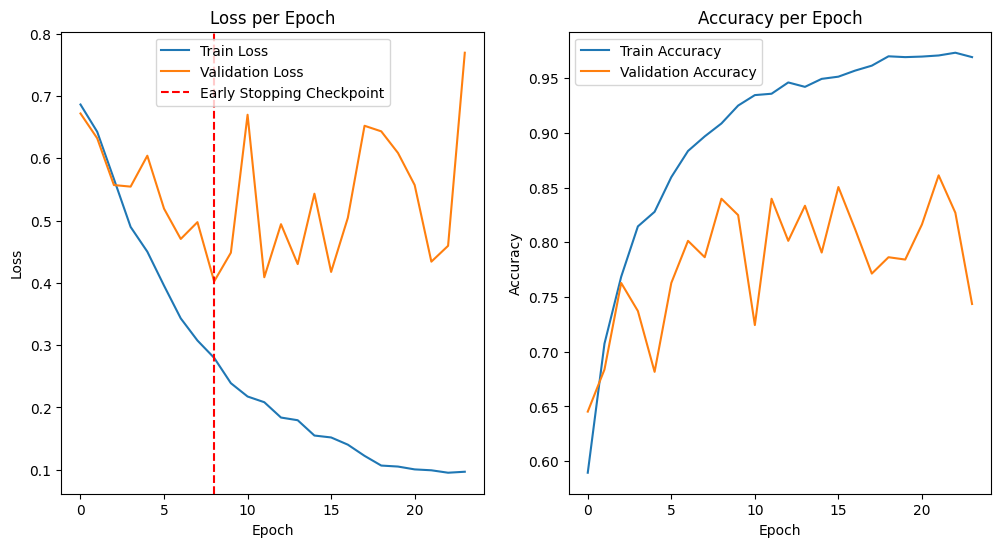

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1953
         1.0       0.97      0.97      0.97      2025

    accuracy                           0.97      3978
   macro avg       0.97      0.97      0.97      3978
weighted avg       0.97      0.97      0.97      3978



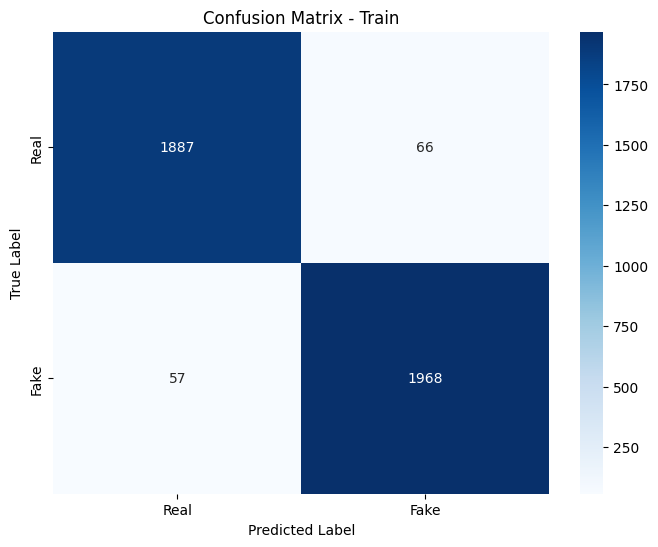

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.58      0.71       254
         1.0       0.65      0.93      0.77       214

    accuracy                           0.74       468
   macro avg       0.78      0.76      0.74       468
weighted avg       0.79      0.74      0.74       468



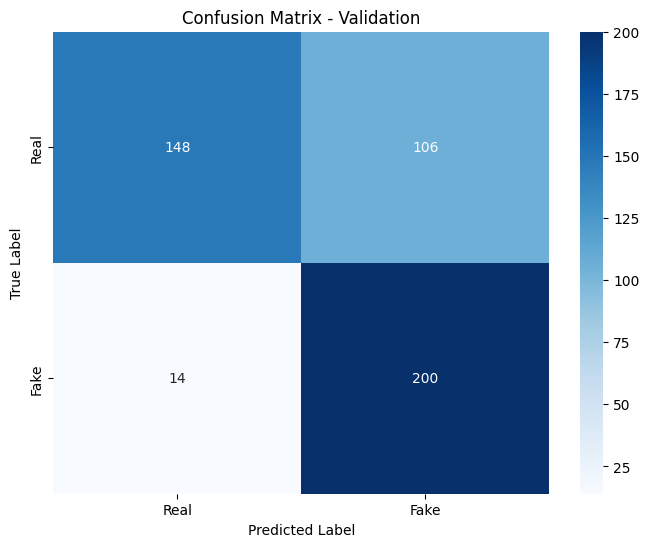

Validation AUC: 0.9001950106703952


In [47]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 128,
    'lstm_hidden_dim': 64,
    'num_lstm_layers': 2,
    'dropout': 0.4,
    'bidirectional': False,
    'freeze': False,
    'n_frames': 20,
    'batch_size': 4,
    'lr': 0.00001,
    'num_epochs': 25,
    'gamma': 0.1,
    'milestones': [32, 64]
}

models_to_train = [
    (ResNetLSTMClassifier, 'ResNetLSTMNoBiClassifier20x224', (224, 224), hyperparameters_1)
]

for model_type, name, size, hyperparameters in models_to_train:
    model = model_type(
        n_linear_hidden=hyperparameters['n_linear_hidden'],
        lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
        num_lstm_layers=hyperparameters['num_lstm_layers'],
        dropout=hyperparameters['dropout'],
        bidirectional=hyperparameters['bidirectional'],
        freeze=hyperparameters['freeze']
    )

    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_val.json', size, device, name)

In [48]:
def test_model(model: nn.Module, data_path: str, n_frames: int, size: Tuple[int, int]):
    batch_size = 1
    epoch_v_loss = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()

    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    test_dataset = VideoDataset(n_frames, data_path, device, 'cache', size, transfor)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    torch.cuda.empty_cache()
    gc.collect()
    
    all_val_labels, all_val_preds = [], []
    test_probs = []
    with torch.no_grad():
        for video_data, labels in tqdm(test_loader, desc="Test", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            output = model(video_data)
            output_probs = torch.sigmoid(output)
            test_probs.extend(output_probs.cpu().numpy())

            loss = criterion(output, labels)
            epoch_v_loss += loss.item()

            output = torch.sigmoid(output).round()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(output.cpu().numpy())

            torch.cuda.empty_cache()
            gc.collect()
        
    val_loss = epoch_v_loss / len(test_loader)
    val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)

    print(f'Test loss: {val_loss:.4f}, Test accuracy: {val_accuracy:.4f}')

    print("Test Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Test')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Test AUC: {val_auc}')

Test loss: 0.8043, Test accuracy: 0.7452
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.59      0.71       306
         1.0       0.66      0.93      0.77       267

    accuracy                           0.75       573
   macro avg       0.78      0.76      0.74       573
weighted avg       0.79      0.75      0.74       573



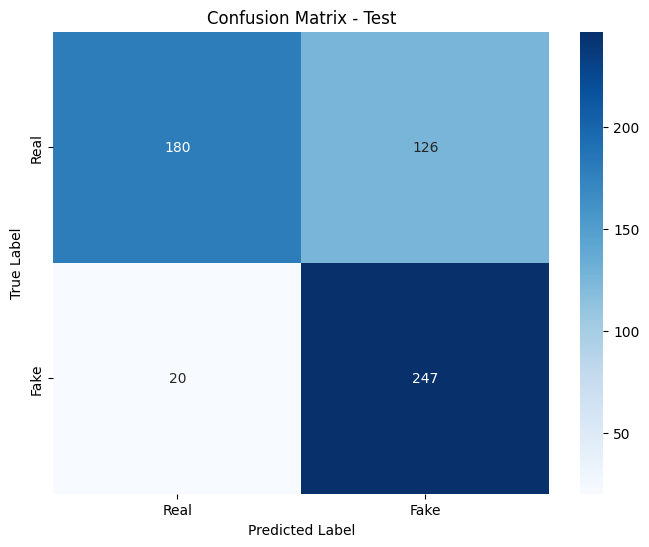

Test AUC: 0.856992484884091


7744

In [49]:
test_model(model, 'output_balenced_test.json', 20, (224, 224))
del model
torch.cuda.empty_cache()
gc.collect()

Test loss: 0.4363, Test accuracy: 0.8063
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.83       306
         1.0       0.82      0.74      0.78       267

    accuracy                           0.81       573
   macro avg       0.81      0.80      0.80       573
weighted avg       0.81      0.81      0.81       573



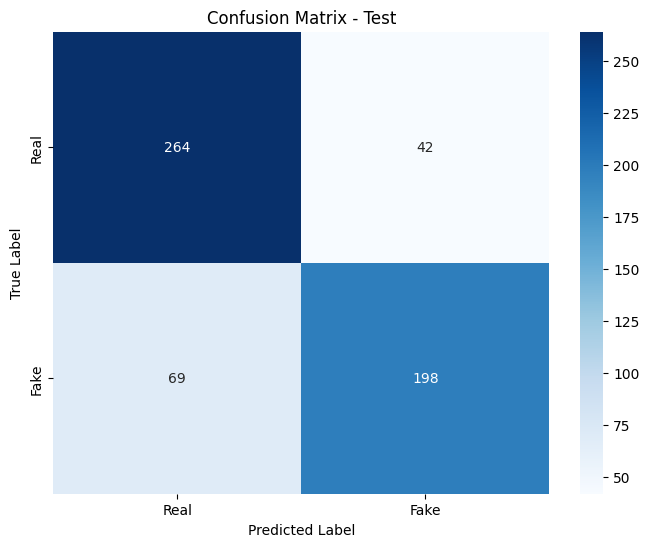

Test AUC: 0.8918875914910284


In [50]:
model_path = '/kaggle/working/early_stopping_ResNetLSTMNoBiClassifier20x224_lstm_checkpoint.pt'
    
model = ResNetLSTMClassifier(
    n_linear_hidden=hyperparameters_1['n_linear_hidden'],
    lstm_hidden_dim=hyperparameters_1['lstm_hidden_dim'],
    num_lstm_layers=hyperparameters_1['num_lstm_layers'],
    dropout=hyperparameters_1['dropout'],
    bidirectional=hyperparameters_1['bidirectional'],
    freeze=hyperparameters_1['freeze']
)
checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint)

test_model(model, 'output_balenced_test.json', 20, (224, 224))